In [508]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

np.random.seed(42)

In [509]:
n_proteins = 5000
n_samples_per_group = 500
total_samples = n_samples_per_group * 2

In [510]:
# Generate protein IDs
protein_ids = [f'Protein_{i+1}' for i in range(n_proteins)]

In [511]:
data = np.zeros((n_proteins, total_samples))

In [512]:
idx_pval_lt_0_01 = np.arange(0, 100)
idx_pval_0_01_to_0_1 = np.arange(100, 200)
idx_non_significant = np.arange(200, n_proteins)

In [513]:
counts = 0

pvals_lt_0_01_counts = 0
pvals_0_01_counts = 0

pvals_lt_0_01 = []
pvals_0_01_to_0_1 = []

while counts < 200:

    fc = np.random.uniform(0.01, 3.0)

    loc = np.random.randint(8, 20)

    scale = 0.5

    group1 = np.random.normal(loc=loc, scale=scale, size=n_samples_per_group)
    group2 = np.random.normal(loc=loc+fc, scale=scale, size=n_samples_per_group)

    t_stat, p_val = ttest_ind(group1, group2, equal_var=False)

    if (p_val <= 0.01) and pvals_lt_0_01_counts < 100:

        pvals_lt_0_01.append(np.concatenate([group1, group2]))

        pvals_lt_0_01_counts += 1
        counts += 1

    elif p_val > 0.01 and pvals_0_01_counts < 100:

        pvals_0_01_to_0_1.append(np.concatenate([group1, group2]))
        pvals_0_01_counts += 1
        counts +=1


In [514]:
num_pval_gt_0_1 = 0

pvals_gt_0_1 = []

while num_pval_gt_0_1 < n_proteins - 200:

    fc = np.random.uniform(0.1, 0.2)

    loc = np.random.randint(8, 20)

    scale = 0.5

    group1 = np.random.normal(loc=loc, scale=scale, size=n_samples_per_group)
    group2 = np.random.normal(loc=loc, scale=scale, size=n_samples_per_group)

    t_stat, p_val = ttest_ind(group1, group2, equal_var=False)

    if p_val > 0.1:

        pvals_gt_0_1.append(np.concatenate([group1, group2]))

        num_pval_gt_0_1 += 1



In [515]:
data = np.concatenate(
    [
        pvals_lt_0_01,
        pvals_0_01_to_0_1,
        pvals_gt_0_1,
    ]
)

In [516]:
data

array([[18.23693042, 18.68422506, 17.54158658, ..., 18.55662935,
        19.16112632, 18.73963795],
       [ 7.76444591,  8.53756214,  8.31605805, ..., 10.71924457,
        11.25340818,  9.9289931 ],
       [15.0902916 , 15.07261936, 14.69038177, ..., 14.79825427,
        15.37763178, 15.10486481],
       ...,
       [15.45336487, 15.84066018, 17.07585866, ..., 16.63849352,
        15.72238054, 15.48996411],
       [10.27453193,  9.67709458,  9.93766369, ...,  9.98108398,
         9.27009351, 10.74761286],
       [13.10374516, 14.00623949, 14.62816365, ..., 14.57286259,
        13.00019864, 14.13461744]])

In [517]:
samples = [f'Sample_{i+1}' for i in range(total_samples)]
df = pd.DataFrame(data, index=protein_ids, columns=samples)
df = df.reset_index(names="Protein")

In [518]:
group_labels = ['Group1'] * n_samples_per_group + ['Group2'] * n_samples_per_group

In [519]:
design_matrix = pd.DataFrame(
    {
        "sample": samples,
        "group": group_labels,
    }
)

In [520]:
design_matrix.to_csv(
    "../tests/input_files/simulated_design_matrix.tsv",
    sep="\t",
    index=False,
)

In [521]:
df.to_csv(
    "../tests/input_files/simulated_proteins.tsv",
    sep="\t",
    index=False,
)

In [522]:
from dpks.quant_matrix import QuantMatrix

quant_matrix = QuantMatrix(
    quantification_file=df,
    design_matrix_file=design_matrix,
)

In [523]:
quant_matrix = quant_matrix.compare(
    method="anova",
    comparisons=("Group2", "Group1"),
    min_samples_per_group=2,
    level="protein",
    multiple_testing_correction_method="fdr_tsbh",
)

/Users/aaron/Documents/projects/dpks/DPKS/dpks/differential_testing.py:252: RuntimeWarning: divide by zero encountered in log10
  quant_matrix.quantitative_data.obs[f"-Log10CorrectedPValue{group_a}-{group_b}"] = -np.log10(


In [524]:
da_df = quant_matrix.row_annotations

In [525]:
da_df[da_df['CorrectedPValueGroup2-Group1'] <= 0.01]

,Protein,DEScoreGroup2-Group1,GroupGroup2Mean,GroupGroup1Mean,GroupGroup2Stdev,GroupGroup1Stdev,Log2FoldChangeGroup2-Group1,PValueGroup2-Group1,GroupGroup2RepCounts,GroupGroup1RepCounts,CorrectedPValueGroup2-Group1,-Log10CorrectedPValueGroup2-Group1
0,Protein_1,0.690516,19.178680,17.984686,0.531972,0.515646,1.193994,1.414909e-182,500,500,1.155509e-180,179.937227
1,Protein_2,NaN,10.643232,8.033308,0.482864,0.516807,2.609924,0.000000e+00,500,500,0.000000e+00,inf
2,Protein_3,0.077352,15.245063,15.032649,0.504583,0.499710,0.212414,3.921299e-11,500,500,1.960649e-09,8.707600
3,Protein_4,NaN,17.349499,14.986282,0.502714,0.517292,2.363217,0.000000e+00,500,500,0.000000e+00,inf
4,Protein_5,1.051978,10.623585,9.007066,0.484373,0.481696,1.616519,1.452406e-291,500,500,1.617452e-289,288.791169
...,...,...,...,...,...,...,...,...,...,...,...,...
95,Protein_96,NaN,18.610285,15.968884,0.492833,0.507339,2.641401,0.000000e+00,500,500,0.000000e+00,inf
96,Protein_97,1.146387,16.811516,15.024840,0.504333,0.485823,1.786676,4.429725e-316,500,500,5.712013e-314,313.243211
97,Protein_98,NaN,19.212159,16.984888,0.498890,0.491245,2.227271,0.000000e+00,500,500,0.000000e+00,inf
98,Protein_99,0.841843,20.331290,18.976289,0.506654,0.488321,1.355001,1.678817e-229,500,500,1.581962e-227,226.800804


In [526]:
da_df[da_df['Protein'] == "Protein_101"]

,Protein,DEScoreGroup2-Group1,GroupGroup2Mean,GroupGroup1Mean,GroupGroup2Stdev,GroupGroup1Stdev,Log2FoldChangeGroup2-Group1,PValueGroup2-Group1,GroupGroup2RepCounts,GroupGroup1RepCounts,CorrectedPValueGroup2-Group1,-Log10CorrectedPValueGroup2-Group1
100,Protein_101,0.026213,14.089278,14.011907,0.506802,0.492208,0.077372,0.0146,500,500,0.671571,0.172908


In [527]:
da_df.sort_values(by="CorrectedPValueGroup2-Group1", ascending=True)

,Protein,DEScoreGroup2-Group1,GroupGroup2Mean,GroupGroup1Mean,GroupGroup2Stdev,GroupGroup1Stdev,Log2FoldChangeGroup2-Group1,PValueGroup2-Group1,GroupGroup2RepCounts,GroupGroup1RepCounts,CorrectedPValueGroup2-Group1,-Log10CorrectedPValueGroup2-Group1
29,Protein_30,NaN,13.122538,11.008827,0.480137,0.504678,2.113711,0.000000,500,500,0.000000,inf
89,Protein_90,NaN,18.380292,16.004745,0.499137,0.476360,2.375547,0.000000,500,500,0.000000,inf
26,Protein_27,NaN,19.984103,16.992685,0.529261,0.518163,2.991419,0.000000,500,500,0.000000,inf
28,Protein_29,NaN,16.920175,14.053346,0.499337,0.489455,2.866829,0.000000,500,500,0.000000,inf
33,Protein_34,NaN,15.971082,12.946519,0.508929,0.478427,3.024564,0.000000,500,500,0.000000,inf
...,...,...,...,...,...,...,...,...,...,...,...,...
407,Protein_408,0.000026,9.016944,9.016865,0.527657,0.496671,0.000079,0.998067,500,500,0.978889,0.009266
3328,Protein_3329,0.000022,9.974827,9.974894,0.498100,0.506196,-0.000067,0.998314,500,500,0.978935,0.009246
4353,Protein_4354,0.000011,10.982342,10.982309,0.503882,0.504706,0.000033,0.999166,500,500,0.979477,0.009006
1565,Protein_1566,0.000009,8.982604,8.982576,0.510904,0.517841,0.000028,0.999324,500,500,0.979477,0.009006


In [528]:
da_df['ProteinNum'] = da_df['Protein'].str.split("_").str[-1].astype(int)

In [529]:
da_df['DAType'] = np.where(da_df['ProteinNum'] <= 100, 1, np.where(da_df['ProteinNum'] < 200, 2, 0))

<Axes: xlabel='Log2FoldChangeGroup2-Group1', ylabel='-Log10CorrectedPValueGroup2-Group1'>

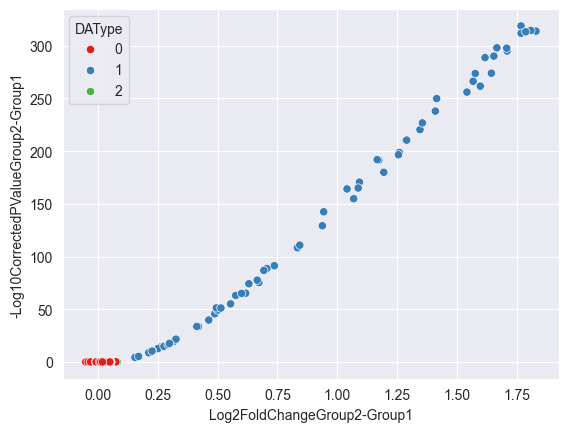

In [530]:
sns.scatterplot(
    data=da_df,
    x="Log2FoldChangeGroup2-Group1",
    y="-Log10CorrectedPValueGroup2-Group1",
    hue="DAType",
    palette="Set1",
)

In [531]:
quant_matrix.quantitative_data.X

array([[18.23693042, 18.68422506, 17.54158658, ..., 18.55662935,
        19.16112632, 18.73963795],
       [ 7.76444591,  8.53756214,  8.31605805, ..., 10.71924457,
        11.25340818,  9.9289931 ],
       [15.0902916 , 15.07261936, 14.69038177, ..., 14.79825427,
        15.37763178, 15.10486481],
       ...,
       [15.45336487, 15.84066018, 17.07585866, ..., 16.63849352,
        15.72238054, 15.48996411],
       [10.27453193,  9.67709458,  9.93766369, ...,  9.98108398,
         9.27009351, 10.74761286],
       [13.10374516, 14.00623949, 14.62816365, ..., 14.57286259,
        13.00019864, 14.13461744]])

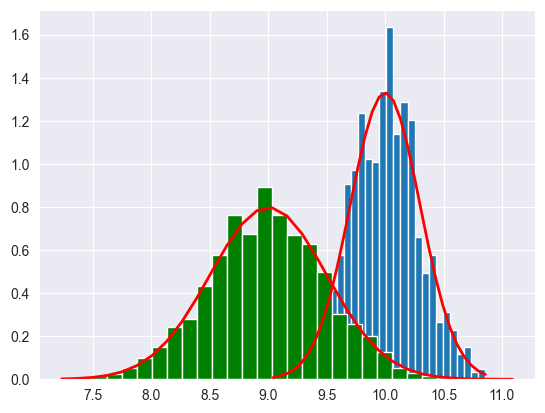

In [459]:
mu, sigma = 10, 0.3 # mean and standard deviation
s = np.random.normal(mu, sigma, 1000)

import matplotlib.pyplot as plt
count, bins, ignored = plt.hist(s, 30, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')


mu, sigma = 9, 0.5 # mean and standard deviation
s = np.random.normal(mu, sigma, 1000)
count, bins, ignored = plt.hist(s, 30, density=True, color='g')
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
plt.show()